# CMIP Scraping Library

Functions for downloading specific fields from CMIP6 model outputs. Turn this into a real library or module later on.

In [22]:
import xarray as xr
import pooch
import pandas as pd
from functools import reduce
import fsspec
from pathlib import Path
import time
import numpy as np
import json
import cftime
import matplotlib.pyplot as plt
import netCDF4 as nc
from itertools import cycle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)



# Handy metpy tutorial working with xarray:
# https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#sphx-glr-tutorials-xarray-tutorial-py
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
from metpy.plots import SkewT

In [2]:
def fetch_var_exact(the_dict,df_og):
    """
    Jamie's code -- fetches variables with precicely defined coordinates 
    
        source_id
        table_id
        variable_id
        
    Returns Xarray containing requested variable
    """
    the_keys = list(the_dict.keys())
    #print(the_keys)
    key0 = the_keys[0]
    #print(key0)
    #print(the_dict[key0])
    hit0 = df_og[key0] == the_dict[key0]
    if len(the_keys) > 1:
        hitnew = hit0
        for key in the_keys[1:]:
            hit = df_og[key] == the_dict[key]
            hitnew = np.logical_and(hitnew,hit)
            #print("total hits: ",np.sum(hitnew))
    else:
        hitnew = hit0
    df_result = df_og[hitnew]
    return df_result

In [3]:
def get_field(variable_id, 
              df,
              source_id,
              experiment_id,
              table_id):
    """
    extracts a single variable field from the model
    """

    var_dict = dict(source_id = source_id, variable_id = variable_id,
                    experiment_id = experiment_id, table_id = table_id)
    
    local_var = fetch_var_exact(var_dict, df)
    zstore_url = local_var['zstore'].array[0]
    the_mapper=fsspec.get_mapper(zstore_url)
    local_var = xr.open_zarr(the_mapper, consolidated=True)
    return local_var

In [4]:
def trim_field(df, lat, lon, years):
    """
    cuts out a specified domain from an xarrray field
    
    lat = (minlat, maxlat)
    lon = (minlon, maxlon)
    """
    new_field = df.sel(lat=slice(lat[0],lat[1]), lon=slice(lon[0],lon[1]))
    
    # handle cftime.DatetimeNoLeap time formatting
    if new_field.time.dtype == 'O':
        new_field = new_field.isel(time=(new_field.time.dt.year >= years[0]))
        #new_field = new_field.isel(time=(new_field.time.dt.year <= years[1]))
    
    # handle numpy.datetime64[ns] time formatting
    elif new_field.time.dtype == '<M8[ns]':
        new_field = new_field.isel(time=(pd.to_datetime(df.time).year >= years[0]))
        #new_field = new_field.isel(time=(pd.to_datetime(df.time).year < years[1]))
        
    return new_field

In [5]:
def find_models(experiment_id, variables):
    """
    Returns a list of models which contain the requested variables at requested intervals

    Parameters
    ----------
    experiment_id : string
        model run selected from the list found here:
            https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit#    
    variables : dict
        key value pairs {"interval":["var1", "var2"]} specifying requested variables at each time interval
    
    Returns
    -------
    models : list
        the source id's for CMIP6 models which fit the requested criteria. Also prints eligible models
        to screen.

    Example
    -------
    In []:   find_models("piControl", {"3hr":['tas', 'huss'], "day":['mrsos']})
    
    Out []:  [GFDL-CM4, GFDL-ESM4]
    """
    # get all the data from google's datastore
    odie = pooch.create(
        path="./.cache",
        base_url="https://storage.googleapis.com/cmip6/",
        registry={
            "pangeo-cmip6.csv": None
        },
    )
    file_path = odie.fetch("pangeo-cmip6.csv")
    df_in = pd.read_csv(file_path)
    
    # select by experiment_id
    df_expt = df_in[(df_in.experiment_id == experiment_id)]
    
    # create a dictionary containing all models that contain req'd variables
    # for each interval
    models = {}
    for key in variables.keys():
        df_var = df_expt[df_expt.table_id == key]
        df_mods = df_var.groupby("source_id")
        models[key] = list(df_mods.groups.keys())
        
    # return models that have ALL req'd variables
    models_pass = list(reduce(lambda i, j: i & j, (set(x) for x in list(models.values()))))
    return models_pass    

In [10]:
def download_data(experiment_id, variables, domain, path, download=True):
    """
    Finds model runs that fit specified criteria, selects a domain and saves fields to disk as NETCDF files.
    Silences exceptions but cancels downloads of buggy/incompatible models.
    
    ** NOTE: Current version only supports datasets with "3hr" and "day" intervals **

    Parameters
    ----------
    experiment_id : string
        model run selected from the list found here:
            https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit#    
    variables : dict
        key value pairs {"interval":["var1", "var2"]} specifying requested variables at each time interval
    domain : dict 
        specify lattitude and longitude bounds and time interval. Example for Thompson, MB, Canada from year 1960 to 2016:
        
        {"lats":(51, 57) 
         "lons":(259, 265) 
         "years":(1960, 2015)}
        
        NOTE: time formatting is inconsistent between models, i.e. some use hours since 01-01-1850 00:00:00, others begin
              1960, others begin at arbitrary year zero for spin up...
    path : str
        location to save netcdf files. e.g. "../CMIP_data"
    download : bool
        set download=False for the first run to ensure all fields are present/correct. Saving to NETCDF can 
        take a long time, especially for large datasets.
    
    Returns
    -------
    None. Prints a message to screen indicating success/failure of each model download
    """
    # get all the data from google's datastore
    odie = pooch.create(
        path="./.cache",
        base_url="https://storage.googleapis.com/cmip6/",
        registry={
            "pangeo-cmip6.csv": None
        },
    )
    file_path = odie.fetch("pangeo-cmip6.csv")
    df_in = pd.read_csv(file_path)
    
    # find which models have required fields at desired intervals
    models_to_use = find_models(experiment_id, variables)
    print(f"found {len(models_to_use)} compatible model runs\n")
    
    for model in models_to_use:
        # download files if no errors (set this to False later on if error occurs) 
        if download:
            do_download = True
        else:
            do_download = False
            
        source_id = model
        # get all the 3hr fields
        table_id = '3hr'
        required_fields = variables['3hr']
        print(f"""Fetching domain:
              source_id = {source_id}
              experiment_id = {experiment_id}
              lats = {domain["lats"]}
              lons = {domain["lons"]}
              years = {domain["years"]}""")
        
        print("acquiring 3hrly data")
        # grab all fields of interest and combine (3hr)
        try:
            my_fields = [get_field(field, df_in, source_id, experiment_id, table_id) for field in variables['3hr']]
            small_fields = [trim_field(field, domain["lats"], domain["lons"], domain["years"]) for field in my_fields]
            ds_3h = xr.combine_by_coords(small_fields, compat="override", combine_attrs="drop_conflicts")
        except IndexError:
            print(f"ERROR: {model}, required '3hr' field(s) missing or empty")
            do_download = False

        # filter extraneous dimensions
        for dim in ["height", "time_bounds", "depth", "depth_bounds", "lat_bnds", "lon_bnds"]:
            try:
                ds_3h = ds_3h.drop(dim)
            except:
                pass
            
        print("acquiring daily data")
        # get all the daily fields
        table_id = 'day'
        required_fields = variables['day']

        # grab all fields of interest and combine (day)
        try:
            my_fields = [get_field(field, df_in, source_id, experiment_id, table_id) for field in variables['day']]
            small_fields = [trim_field(field, domain["lats"], domain["lons"], domain["years"]) for field in my_fields]
            ds_day = xr.combine_by_coords(small_fields, compat="override", combine_attrs="drop_conflicts")
        except IndexError:
            print(f"ERROR: {model}, required 'day' field(s) missing or empty")
            do_download = False
        except KeyError:
            print(f"ERROR: {model}, coordinate system not supported")
            do_download = False
        
        # filter extraneous dimensions
        for dim in ["height", "time_bounds", "depth", "depth_bounds", "lat_bnds", "lon_bnds"]:
            try:
                ds_day = ds_day.drop(dim)
            except:
                pass
        
        # interpolate daily data onto the 3hourly and merge.
        print("interpolating")
        try:
            day_interp = ds_day.interp_like(ds_3h).chunk({"time":-1})
            print("merging datasets")
            full_dataset = ds_3h.merge(day_interp, compat='override').metpy.quantify().chunk({"time":10000})
        except TypeError:
            print(f"ERROR: {model}, unsupported datetime formatting")
            do_download = False
            
        print("scrubbing NaN values")
        # day_interp = day_interp.interpolate_na(dim="time") # this needs to be fixed. working on
        # 2022-04-10, pandas changed function since then???
        
        if do_download:
            print(f"saving {source_id} to disk as netcdf")
            full_dataset.to_netcdf(f"{path}/{source_id}-{experiment_id}.nc", engine="netcdf4")
            print("success\n\n")
        else:
            print(f"parsed {source_id}\n\n")


In [47]:
def make_betts_fig10(nc_data, save_loc=None):
    """
    Creates a plot matching figure 10 from 'Land-Surface-Atmosphere Coupling in Observations and Models', by Alan K Betts (2009)
    
    Parameters
    ----------
    nc_data : string
        path do NETCDF data file saved using download_data() function in this library
        
    save_loc : string
        location to save the figure. default behavior is to render the figure but not save. 
            
    Returns
    -------
    None. Prints a message to screen for models which fail to render
    """
    # open the data and re-convert time to cftime so xarray is happy
    data_in = xr.open_dataset(nc_data, engine="netcdf4", decode_times=False).metpy.quantify()
    #data_in["time"] = cftime.num2date(data_in.time, "hours since 1850-01-01 00:00:00", calendar="noleap", has_year_zero=True)
    data_in["time"] = cftime.num2date(data_in.time, "hours since 0001-01-01 03:00:00", calendar="noleap", has_year_zero=True)

    # constant for surface pressure
    ps = 100000 * units.Pa 
    
    # use metpy to convert humidity field to dew point temp
    try:
        data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)
    except ValueError:
        data_in["tas"] = data_in.tas * units.kelvin
        data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)

    # compute the spatial average
    spatial_average = data_in.mean(dim=("lat", "lon")).dropna(dim="time")

    # sort the file into 6 groups based on soil moisture content
    the_max = float(spatial_average.mrsos.max().values)
    the_min = float(spatial_average.mrsos.min().values)
    the_range =  the_max - the_min

    spatial_average["soil_moisture_grp"] = ((spatial_average.mrsos / (the_range / 6)).round() * (the_range / 6)).round()
    gbysoil = spatial_average.groupby(spatial_average.soil_moisture_grp)

    # remove the highest and lowest values, they are usually too sparse to plot
    mrsos_keys = list(gbysoil.groups.keys())
    mrsos_keys.remove(max(mrsos_keys))
    mrsos_keys.remove(min(mrsos_keys))

    # calculate and plot the average diurnal cycle of lcl height
    fig, ax = plt.subplots()
    lposition = 1.1 # for annotating plot
    lines = ["--","-.",":"]
    linecycler = cycle(lines)
    for key in mrsos_keys:
        # group by hour
        hourly_data = gbysoil[key].groupby(gbysoil[key].time.dt.hour).mean(dim="time") 

        # find and plot the lcl
        plcl, tlcl = mpcalc.lcl(ps, hourly_data.tas, hourly_data.td)
        plcl_hpa = plcl / 100

        # assign colors to match Betts
        if key == min(mrsos_keys):
            plot_kwargs = {"color":"darkblue"}
        elif key == max(mrsos_keys):
            plot_kwargs = {"color":"red"}
        else:
            plot_kwargs = {"color":"black", "linestyle":next(linecycler), "linewidth":0.8}

        # append hour 24 to match hour 0
        the_time = np.append(hourly_data.hour.values, 24)
        the_lcl = np.append(plcl_hpa, plcl_hpa[0])
        ax.plot(the_time, the_lcl, label=f"{round(key)} kg/m$^3$", **plot_kwargs)

    # make the plot match Betts fig 11
    plt.gca().invert_yaxis()
    ax.set_xlabel("Local Time")
    ax.set_ylabel("P$_{LCL}$ (hPa)")
    ax.legend(loc="upper center")
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks((0,6,12,18,24), labels=(18, 24, 0, 6, 12))
    ax.set_xlim(0,24)
    ax.set_title(str(nc_data)[5:-9]);
    
    if save_loc != None:
        plt.savefig(f"{save_loc}/{str(nc_data)[5:-9]}-betts-fig10")


In [8]:
my_domain = {"lats":(51, 57), "lons":(259, 265), "years":(1960, 2015)}

In [11]:
download_data("historical", {"3hr":['tas', 'huss'], "day":['mrsos']}, my_domain, "./data", download=False)

found 34 compatible model runs

Fetching domain:
              source_id = CNRM-CM6-1
              experiment_id = historical
              lats = (51, 57)
              lons = (259, 265)
              years = (1960, 2015)
acquiring 3hrly data
acquiring daily data
interpolating
merging datasets
scrubbing NaN values
parsed CNRM-CM6-1


Fetching domain:
              source_id = EC-Earth3-Veg
              experiment_id = historical
              lats = (51, 57)
              lons = (259, 265)
              years = (1960, 2015)
acquiring 3hrly data


KeyboardInterrupt: 

data/SAM0-UNICON-historical-fig10.nc failed to plot


/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


data/KACE-1-0-G-historical-fig10.nc failed to plot


/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


data/GFDL-CM4-piControl-fig10.nc failed to plot


/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
/srv/conda/envs/notebook/lib/python3.9/site-packages/metpy/calc/thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ens

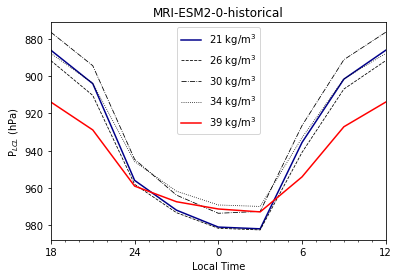

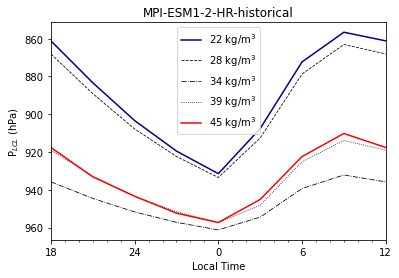

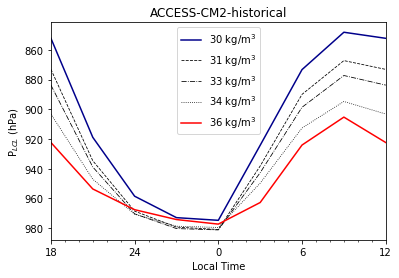

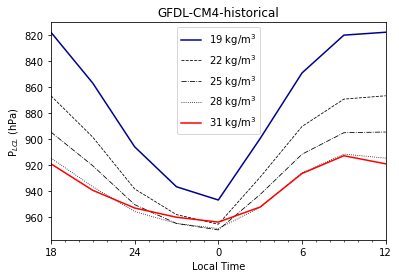

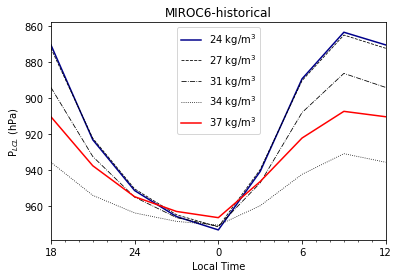

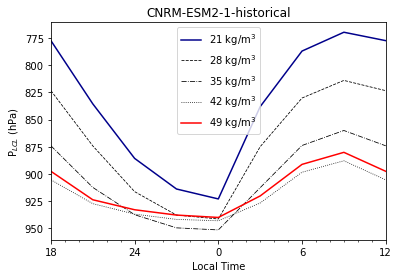

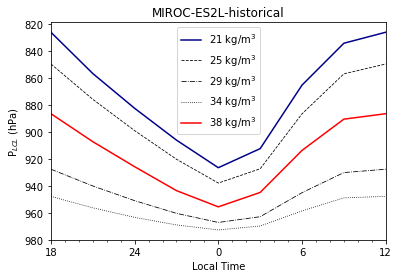

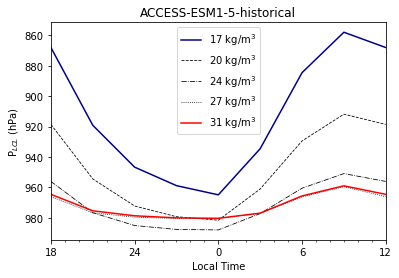

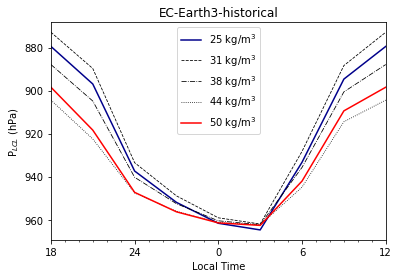

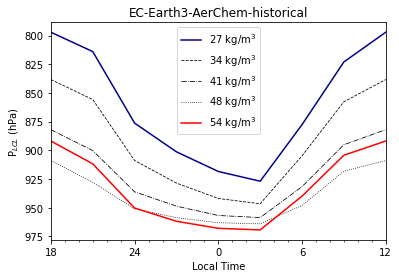

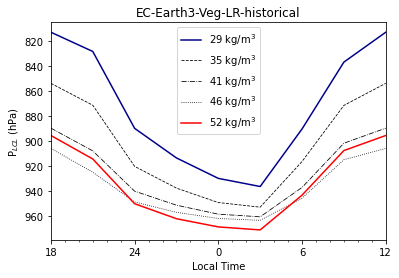

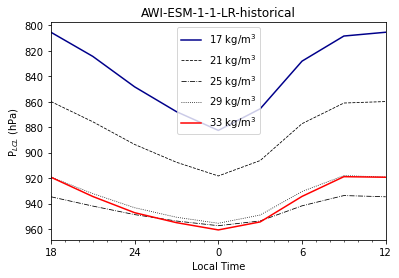

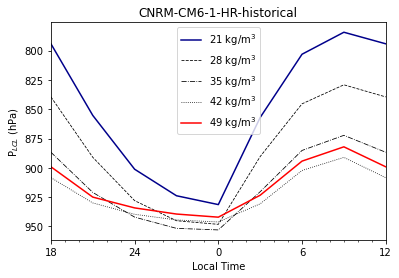

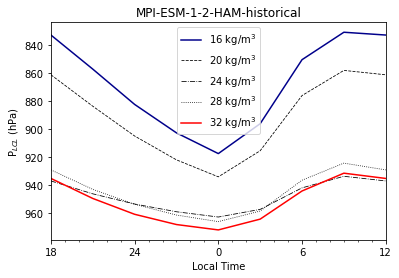

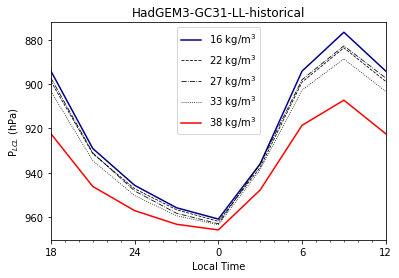

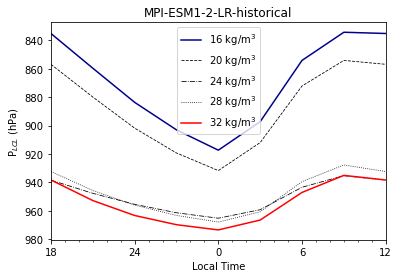

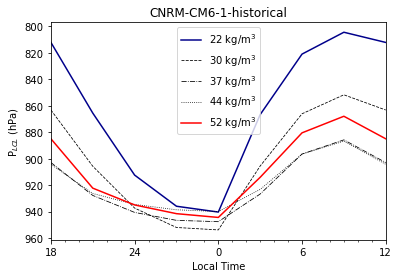

In [50]:
file_path = Path("data/")
files = list(file_path.glob("*fig10*"))
for file in files:
    try:
        make_betts_fig10(file, save_loc="./figures")
    except ValueError:
        print(f"{file} failed to plot")